In [10]:
# 0. 라이브러리 설치 및 로드
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec
import math
from influxdb_client import InfluxDBClient
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import StackingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import shap

# 1. 폰트 설정
font_path = "/System/Library/Fonts/Supplemental/AppleGothic.ttf"
fontprop = fm.FontProperties(fname=font_path)
font_name = fontprop.get_name()
mpl.rcParams['font.family'] = font_name
mpl.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
plt.rcParams['font.family'] = font_name

# 2. InfluxDB 연결 함수
def get_influx_client():
    INFLUX_URL   = "https://influx.aiot2.live"
    INFLUX_TOKEN = "RmaabELI9VpYPRu4nt_xBZX5l3Gv5lx8XnR4mVZnqep4Ya3eYrfpLUk4Y4dYE4J0mlcFHFPLUCKh8a4jq_lMNw=="
    INFLUX_ORG   = "aiot2-team2-coffee"
    INFLUX_BUCKET= "coffee-mqtt"
    client = InfluxDBClient(url=INFLUX_URL, token=INFLUX_TOKEN, org=INFLUX_ORG)
    return client, INFLUX_BUCKET

sensor_types = ["temperature", "humidity", "co2"]
target_locations = ["8인 책상", "왼쪽 뒤", "안쪽벽 중앙", "보드"]

# InfluxDB 연결
client, INFLUX_BUCKET = get_influx_client()
read_api = client.query_api()

sensor_filter = ' or '.join([f'r["type"] == "{t}"' for t in sensor_types])
location_filter = ' or '.join([f'r["location"] == "{loc}"' for loc in target_locations])

flux = f'''
from(bucket: "{INFLUX_BUCKET}")
  |> range(start: -7d)
  |> filter(fn: (r) => r["_measurement"] == "sensor")
  |> filter(fn: (r) => r["_field"] == "value")
  |> filter(fn: (r) => {sensor_filter})
  |> filter(fn: (r) => {location_filter})
  |> aggregateWindow(every: 5m, fn: mean, createEmpty: false)
  |> yield(name: "mean")
'''

In [11]:
# 데이터 쿼리 및 전처리
df = read_api.query_data_frame(flux)
if isinstance(df, list):
    df = pd.concat(df)

df = df.reset_index().rename(columns={"_time": "time"}).set_index("time")

pivot_df = df.pivot_table(index=['time', 'location'], columns='type', values='_value', aggfunc='first').reset_index()
pivot_df = pivot_df.sort_values(by='time')

# 면적 매핑
location_area_map = {"8인 책상": 64.65, "왼쪽 뒤": 109.21, "안쪽벽 중앙": 25.13, "보드": 31.59}
pivot_df['area'] = pivot_df['location'].map(location_area_map)
pivot_df['co2_per_area'] = pivot_df['co2'] / pivot_df['area']

# 결측치 보정 (IterativeImputer)
imputer = IterativeImputer(random_state=42)
imputed = imputer.fit_transform(pivot_df[['co2', 'humidity', 'temperature']])
pivot_df[['co2', 'humidity', 'temperature']] = imputed


/opt/homebrew/anaconda3/lib/python3.12/site-packages/influxdb_client/client/warnings.py:31: MissingPivotFunction: The query doesn't contains the pivot() function.

The result will not be shaped to optimal processing by pandas.DataFrame. Use the pivot() function by:

    
from(bucket: "coffee-mqtt")
  |> range(start: -7d)
  |> filter(fn: (r) => r["_measurement"] == "sensor")
  |> filter(fn: (r) => r["_field"] == "value")
  |> filter(fn: (r) => r["type"] == "temperature" or r["type"] == "humidity" or r["type"] == "co2")
  |> filter(fn: (r) => r["location"] == "8인 책상" or r["location"] == "왼쪽 뒤" or r["location"] == "안쪽벽 중앙" or r["location"] == "보드")
  |> aggregateWindow(every: 5m, fn: mean, createEmpty: false)
  |> yield(name: "mean")
 |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

You can disable this warning by:
    import warnings
    from influxdb_client.client.warnings import MissingPivotFunction

    warnings.simplefilter("ignore", MissingPivotFunction)

Fo

In [12]:
# 3. 특징 공학
def calculate_pmv(t, rh):
    return 0.303 * (t - 23.5) + 0.028 * (rh - 50)

def calculate_aqi(co2):
    return np.where(co2 > 1000, (co2 - 1000) / 500, 0)

def compute_discomfort_index(t, rh):
    return 0.81 * t + 0.01 * rh * (0.99 * t - 14.3) + 46.3

def interpret_comfort_index(ci):
    if ci < -0.3:
        return "불쾌"
    elif ci <= 0.3:
        return "보통"
    else:
        return "쾌적"

pivot_df['PMV'] = calculate_pmv(pivot_df['temperature'], pivot_df['humidity'])
pivot_df['AQI'] = calculate_aqi(pivot_df['co2'])
pivot_df['thermal_stress'] = pivot_df['temperature'] * pivot_df['PMV']
pivot_df['air_quality_impact'] = np.log(pivot_df['AQI'] + 1e-6) * pivot_df['humidity']


In [20]:
# 4. 타겟 재정의 
pivot_df['comfort_index'] = 0.5 * pivot_df['PMV'] + 0.5 * pivot_df['AQI']
pivot_df['comfort_state'] = pivot_df['comfort_index'].apply(interpret_comfort_index)
pivot_df['DI'] = compute_discomfort_index(pivot_df['temperature'], pivot_df['humidity'])


# 5. 최종 feature 세트 재정의
final_features = ['PMV', 'AQI', 'humidity', 'thermal_stress', 'air_quality_impact']
X = pivot_df[final_features].fillna(0)
y = pivot_df['comfort_index']


In [14]:
# 6. 모델 정의
model = XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.1,
    max_depth=4,
    n_estimators=200,
    subsample=0.8
)
# 7. 시계열 검증
results = []
tscv = TimeSeriesSplit(n_splits=5, test_size=24*3)

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    rmse = np.sqrt(mean_squared_error(y_val, preds))
    mae = mean_absolute_error(y_val, preds)
    r2 = r2_score(y_val, preds)

    results.append((fold, rmse, mae, r2))

results_df = pd.DataFrame(results, columns=['Fold', 'RMSE', 'MAE', 'R2'])
print("\n📊 Fold별 검증 성능:")
print(results_df)
print("\n📈 평균 성능:")
print(results_df[['RMSE', 'MAE', 'R2']].mean())



📊 Fold별 검증 성능:
   Fold      RMSE       MAE        R2
0     0  0.001297  0.001053  0.999104
1     1  0.001613  0.001257  0.999796
2     2  0.008768  0.004873  0.997034
3     3  0.008798  0.005309  0.994457
4     4  0.005639  0.003298  0.998673

📈 평균 성능:
RMSE    0.005223
MAE     0.003158
R2      0.997813
dtype: float64


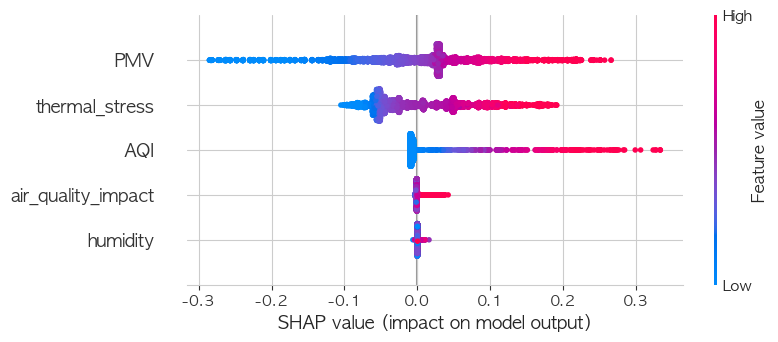

In [15]:
# 8. SHAP 해석
explainer = shap.Explainer(model, X)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values)


# 민감도 분석 
### 특정 feature를 ±10%, ±20%, ±30% 변동시켰을 때 comfort_index 예측값이 얼마나 변하는지 수치화.

           PMV       AQI  humidity  thermal_stress  air_quality_impact
-30%  0.044637  0.002259  0.000603        0.016716            0.001411
-20%  0.030892  0.001477  0.000586        0.010422            0.000795
-10%  0.015881  0.000764  0.000457        0.004275            0.000408
10%   0.016247  0.000759  0.000423        0.003520            0.000336
20%   0.031429  0.001400  0.000598        0.006328            0.000510
30%   0.045890  0.001987  0.000654        0.008909            0.000730


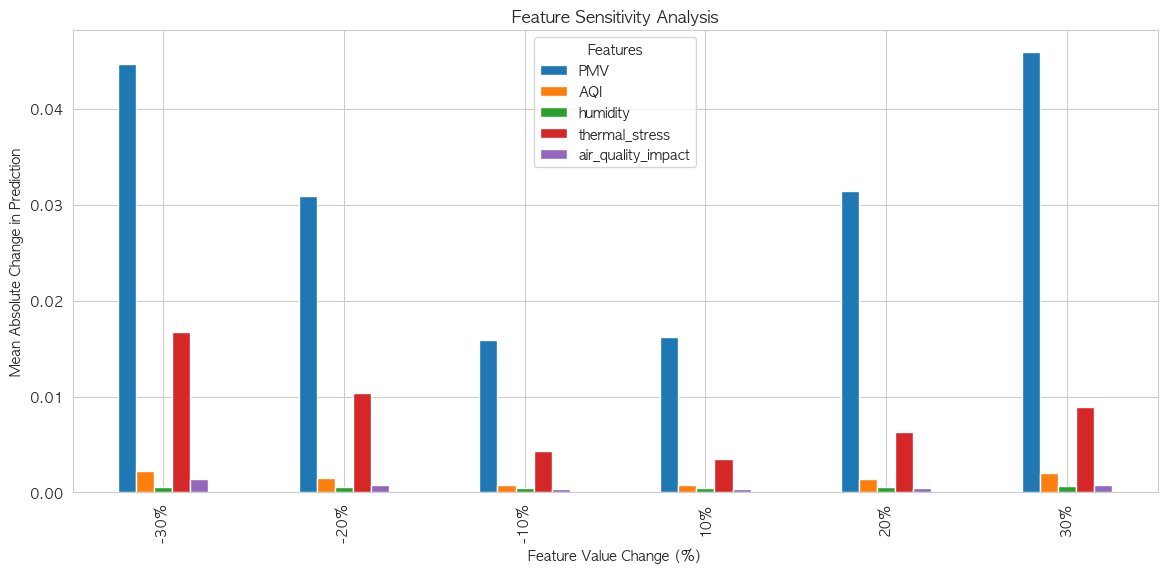

In [16]:

def sensitivity_analysis(model, X, feature_list, percentage_changes=[-0.3, -0.2, -0.1, 0.1, 0.2, 0.3]):
    """
    모델과 입력 데이터에 대해 feature별 민감도 분석 수행
    """
    base_pred = model.predict(X)
    sensitivity_result = {}

    for feature in feature_list:
        changes = []
        for pct in percentage_changes:
            X_modified = X.copy()
            X_modified[feature] *= (1 + pct)
            pred_modified = model.predict(X_modified)
            diff = np.mean(np.abs(pred_modified - base_pred))  # 평균 절대 변화량
            changes.append(diff)
        sensitivity_result[feature] = changes

    result_df = pd.DataFrame(sensitivity_result, index=[f"{int(pct*100)}%" for pct in percentage_changes])
    return result_df

important_features = ['PMV', 'AQI', 'humidity', 'thermal_stress', 'air_quality_impact']
sensitivity_df = sensitivity_analysis(model, X, important_features)

print(sensitivity_df)

# 시각화
sensitivity_df.plot(kind='bar', figsize=(14, 6))
plt.title("Feature Sensitivity Analysis")
plt.ylabel("Mean Absolute Change in Prediction")
plt.xlabel("Feature Value Change (%)")
plt.legend(title="Features")
plt.grid(True)
plt.show()

# 하이퍼 파라미터 튜닝

In [17]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

xgb = XGBRegressor(objective='reg:squarederror')

tscv = TimeSeriesSplit(n_splits=5, test_size=24*3)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)
print("Best RMSE Score:", -grid_search.best_score_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1

In [18]:
import joblib
def save_model(model, path='model.pkl'):
    joblib.dump(model, path)

# 저장
save_model(model, 'model.pkl')

In [19]:
print(pivot_df[['time', 'location', 'comfort_index', 'comfort_state', 'DI']].tail(5))


type                             time location  comfort_index comfort_state  \
6065        2025-04-30 05:40:00+00:00    8인 책상       0.090700            보통   
6068        2025-04-30 05:40:00+00:00     왼쪽 뒤       0.286567            보통   
6070 2025-04-30 05:43:43.170256+00:00       보드      -0.142300            보통   
6069 2025-04-30 05:43:43.170256+00:00    8인 책상       0.093033            보통   
6071 2025-04-30 05:43:43.170256+00:00     왼쪽 뒤       0.302050            쾌적   

type         DI  
6065  70.769390  
6068  70.026960  
6070  68.855140  
6069  70.787302  
6071  70.199810  
